In [60]:
# !pip install prophet
# !pip install plotly
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### FB Prophet validation

In [2]:
p_ex_df = pd.read_csv('example_wp_log_peyton_manning.csv')
m = Prophet()
m.fit(p_ex_df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -19.4685


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7976.11     0.0101103       286.068           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7993.56    0.00101134       304.061       0.582       0.582      242   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     261       7995.92   4.81029e-05       146.043   3.702e-07       0.001      353  LS failed, Hessian reset 
     299       7996.65   0.000581528       81.1695           1           1      394   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       7999.51   0.000319467       223.369      0.5511      0.5511      520   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     465       8000.88   0.000146007       378.592   5.125e-07       0.001      6

In [3]:
future = m.make_future_dataframe(periods=365)
future.tail()

,ds
3265,2017-01-15
3266,2017-01-16
3267,2017-01-17
3268,2017-01-18
3269,2017-01-19


### Load training data and preprocess

In [4]:
# So there are basically 3 countries x 3 products x 2 stores = 18 series to predict.
df = pd.read_csv('train.csv')
countryList = list(df['country'].unique())
productList = list(df['product'].unique())
storeList = list(df['store'].unique())
print('Countries: ', countryList)
print('Products: ', productList)
print('Stores: ', storeList)

41  LS failed, Hessian reset 
     499       8001.34   2.31846e-05       57.5935      0.2347      0.2347      681   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599       8003.05   0.000352272       128.594      0.7035      0.7035      796   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     665       8003.36   0.000107718       282.455   4.212e-07       0.001      917  LS failed, Hessian reset 
     699       8003.58   4.75635e-05       68.4917      0.3593           1      958   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     799       8004.21    3.4784e-05       86.4645   1.729e-07       0.001     1147  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     854       8004.63   5.73705e-05       103.786   6.725e-07       0.001     1258  LS failed, Hessian reset 
     879

In [5]:
df_prep = pd.get_dummies(df, columns=['country', 'product', 'store'])

In [6]:
df_prep.head()

,row_id,date,num_sold,country_Finland,country_Norway,country_Sweden,product_Kaggle Hat,product_Kaggle Mug,product_Kaggle Sticker,store_KaggleMart,store_KaggleRama
0,0,2015-01-01,329,1,0,0,0,1,0,1,0
1,1,2015-01-01,520,1,0,0,1,0,0,1,0
2,2,2015-01-01,146,1,0,0,0,0,1,1,0
3,3,2015-01-01,572,1,0,0,0,1,0,0,1
4,4,2015-01-01,911,1,0,0,1,0,0,0,1


In [7]:
df_prep.columns

Index(['row_id', 'date', 'num_sold', 'country_Finland', 'country_Norway',
       'country_Sweden', 'product_Kaggle Hat', 'product_Kaggle Mug',
       'product_Kaggle Sticker', 'store_KaggleMart', 'store_KaggleRama'],
      dtype='object')

In [8]:
# Generate dataframe for each series
df_dict = {}
for country in ['country_Finland', 'country_Norway', 'country_Sweden']:
    for product in ['product_Kaggle Hat', 'product_Kaggle Mug', 'product_Kaggle Sticker']:
        for store in ['store_KaggleMart', 'store_KaggleRama']:
            name = country.split('_')[1] + '_' + product.split('_')[1] + '_' + store.split('_')[1]
            currdf = df_prep[(df_prep[country] == 1) & (df_prep[product] == 1) & (df_prep[store] == 1)][['date', 'num_sold']]
            df_dict[name] = currdf

In [9]:
df_dict.keys()

dict_keys(['Finland_Kaggle Hat_KaggleMart', 'Finland_Kaggle Hat_KaggleRama', 'Finland_Kaggle Mug_KaggleMart', 'Finland_Kaggle Mug_KaggleRama', 'Finland_Kaggle Sticker_KaggleMart', 'Finland_Kaggle Sticker_KaggleRama', 'Norway_Kaggle Hat_KaggleMart', 'Norway_Kaggle Hat_KaggleRama', 'Norway_Kaggle Mug_KaggleMart', 'Norway_Kaggle Mug_KaggleRama', 'Norway_Kaggle Sticker_KaggleMart', 'Norway_Kaggle Sticker_KaggleRama', 'Sweden_Kaggle Hat_KaggleMart', 'Sweden_Kaggle Hat_KaggleRama', 'Sweden_Kaggle Mug_KaggleMart', 'Sweden_Kaggle Mug_KaggleRama', 'Sweden_Kaggle Sticker_KaggleMart', 'Sweden_Kaggle Sticker_KaggleRama'])

In [10]:
df_dict['Finland_Kaggle Hat_KaggleMart'].head()

,date,num_sold
1,2015-01-01,520
19,2015-01-02,493
37,2015-01-03,535
55,2015-01-04,544
73,2015-01-05,378


In [11]:
df.head()

,row_id,date,country,store,product,num_sold
0,0,2015-01-01,Finland,KaggleMart,Kaggle Mug,329
1,1,2015-01-01,Finland,KaggleMart,Kaggle Hat,520
2,2,2015-01-01,Finland,KaggleMart,Kaggle Sticker,146
3,3,2015-01-01,Finland,KaggleRama,Kaggle Mug,572
4,4,2015-01-01,Finland,KaggleRama,Kaggle Hat,911


In [12]:
df_pivot = df.pivot_table('num_sold', ['date'], ['country', 'store', 'product'])

In [13]:
df_pivot.head()

country       Finland                                                  \
store      KaggleMart                           KaggleRama              
product    Kaggle Hat Kaggle Mug Kaggle Sticker Kaggle Hat Kaggle Mug   
date                                                                    
2015-01-01        520        329            146        911        572   
2015-01-02        493        318            127        794        544   
2015-01-03        535        360            141        843        579   
2015-01-04        544        332            125        873        582   
2015-01-05        378        243            102        668        423   

country                       Norway                                       \
store                     KaggleMart                           KaggleRama   
product    Kaggle Sticker Kaggle Hat Kaggle Mug Kaggle Sticker Kaggle Hat   
date                                                                        
2015-01-01            283        906        526            250       1461   
2015-01-02            249        845        538            237       1446   
2015-01-03            265        930        614            254       1631   
2015-01-04            245        889        589            255       1540   
2015-01-05            187        671        435            184       1126   

country                                  Sweden                            \
store                                KaggleMart                             
product    Kaggle Mug Kaggle Sticker Kaggle Hat Kaggle Mug Kaggle Sticker   
date                                                                        
2015-01-01       1005            395        624        440            175   
2015-01-02        949            415        572        384            155   
2015-01-03       1029            451        630        420            173   
2015-01-04        957            455        697        406            169   
2015-01-05        739            310        442        298            127   

country                                          
store      KaggleRama                            
product    Kaggle Hat Kaggle Mug Kaggle Sticker  
date                                             
2015-01-01       1195        706            324  
2015-01-02        986        653            293  
2015-01-03       1167        734            319  
2015-01-04       1112        657            300  
2015-01-05        796        512            227

In [14]:
df_pivot.columns = df_pivot.columns.map('_'.join).str.strip('_')

In [15]:
df_pivot.head()

,Finland_KaggleMart_Kaggle Hat,Finland_KaggleMart_Kaggle Mug,Finland_KaggleMart_Kaggle Sticker,Finland_KaggleRama_Kaggle Hat,Finland_KaggleRama_Kaggle Mug,Finland_KaggleRama_Kaggle Sticker,Norway_KaggleMart_Kaggle Hat,Norway_KaggleMart_Kaggle Mug,Norway_KaggleMart_Kaggle Sticker,Norway_KaggleRama_Kaggle Hat,Norway_KaggleRama_Kaggle Mug,Norway_KaggleRama_Kaggle Sticker,Sweden_KaggleMart_Kaggle Hat,Sweden_KaggleMart_Kaggle Mug,Sweden_KaggleMart_Kaggle Sticker,Sweden_KaggleRama_Kaggle Hat,Sweden_KaggleRama_Kaggle Mug,Sweden_KaggleRama_Kaggle Sticker
date,,,,,,,,,,,,,,,,,,
2015-01-01,520,329,146,911,572,283,906,526,250,1461,1005,395,624,440,175,1195,706,324
2015-01-02,493,318,127,794,544,249,845,538,237,1446,949,415,572,384,155,986,653,293
2015-01-03,535,360,141,843,579,265,930,614,254,1631,1029,451,630,420,173,1167,734,319
2015-01-04,544,332,125,873,582,245,889,589,255,1540,957,455,697,406,169,1112,657,300
2015-01-05,378,243,102,668,423,187,671,435,184,1126,739,310,442,298,127,796,512,227


In [16]:
df_pivot.tail()

,Finland_KaggleMart_Kaggle Hat,Finland_KaggleMart_Kaggle Mug,Finland_KaggleMart_Kaggle Sticker,Finland_KaggleRama_Kaggle Hat,Finland_KaggleRama_Kaggle Mug,Finland_KaggleRama_Kaggle Sticker,Norway_KaggleMart_Kaggle Hat,Norway_KaggleMart_Kaggle Mug,Norway_KaggleMart_Kaggle Sticker,Norway_KaggleRama_Kaggle Hat,Norway_KaggleRama_Kaggle Mug,Norway_KaggleRama_Kaggle Sticker,Sweden_KaggleMart_Kaggle Hat,Sweden_KaggleMart_Kaggle Mug,Sweden_KaggleMart_Kaggle Sticker,Sweden_KaggleRama_Kaggle Hat,Sweden_KaggleRama_Kaggle Mug,Sweden_KaggleRama_Kaggle Sticker
date,,,,,,,,,,,,,,,,,,
2018-12-27,573,414,177,1068,652,308,898,568,270,1604,1108,436,672,420,196,1127,745,319
2018-12-28,841,499,223,1398,895,431,1162,731,361,2178,1333,662,874,555,260,1540,990,441
2018-12-29,1107,774,296,1895,1398,559,1650,1113,518,2884,1816,874,1106,720,348,2169,1438,596
2018-12-30,1113,757,326,1878,1241,554,1809,1052,500,2851,1935,833,1133,730,336,2138,1303,587
2018-12-31,822,469,238,1231,831,360,1124,728,351,2128,1383,561,823,570,250,1441,1004,388


In [17]:
df_pivot.iloc[366]

Finland_KaggleMart_Kaggle Hat         524
Finland_KaggleMart_Kaggle Mug         316
Finland_KaggleMart_Kaggle Sticker     146
Finland_KaggleRama_Kaggle Hat        1020
Finland_KaggleRama_Kaggle Mug         648
Finland_KaggleRama_Kaggle Sticker     254
Norway_KaggleMart_Kaggle Hat          859
Norway_KaggleMart_Kaggle Mug          561
Norway_KaggleMart_Kaggle Sticker      228
Norway_KaggleRama_Kaggle Hat         1430
Norway_KaggleRama_Kaggle Mug          996
Norway_KaggleRama_Kaggle Sticker      436
Sweden_KaggleMart_Kaggle Hat          679
Sweden_KaggleMart_Kaggle Mug          428
Sweden_KaggleMart_Kaggle Sticker      183
Sweden_KaggleRama_Kaggle Hat         1210
Sweden_KaggleRama_Kaggle Mug          691
Sweden_KaggleRama_Kaggle Sticker      366
Name: 2016-01-02, dtype: int64

In [18]:
df_pivot.shape

(1461, 18)

In [19]:
df_target = df_pivot[['Finland_KaggleMart_Kaggle Hat']].iloc[0:-366]
df_target['ds'] = df_target.index
df_target['y'] = df_target['Finland_KaggleMart_Kaggle Hat']
df_target = df_target.reset_index()[['ds', 'y']]
df_target.head()

,ds,y
0,2015-01-01,520
1,2015-01-02,493
2,2015-01-03,535
3,2015-01-04,544
4,2015-01-05,378


In [20]:
df_prop = pd.concat([df_target, df_pivot.drop(['Finland_KaggleMart_Kaggle Hat'], axis=1).reset_index().iloc[0:-366]], axis=1)
df_prop.head()

,ds,y,date,Finland_KaggleMart_Kaggle Mug,Finland_KaggleMart_Kaggle Sticker,Finland_KaggleRama_Kaggle Hat,Finland_KaggleRama_Kaggle Mug,Finland_KaggleRama_Kaggle Sticker,Norway_KaggleMart_Kaggle Hat,Norway_KaggleMart_Kaggle Mug,Norway_KaggleMart_Kaggle Sticker,Norway_KaggleRama_Kaggle Hat,Norway_KaggleRama_Kaggle Mug,Norway_KaggleRama_Kaggle Sticker,Sweden_KaggleMart_Kaggle Hat,Sweden_KaggleMart_Kaggle Mug,Sweden_KaggleMart_Kaggle Sticker,Sweden_KaggleRama_Kaggle Hat,Sweden_KaggleRama_Kaggle Mug,Sweden_KaggleRama_Kaggle Sticker
0,2015-01-01,520,2015-01-01,329,146,911,572,283,906,526,250,1461,1005,395,624,440,175,1195,706,324
1,2015-01-02,493,2015-01-02,318,127,794,544,249,845,538,237,1446,949,415,572,384,155,986,653,293
2,2015-01-03,535,2015-01-03,360,141,843,579,265,930,614,254,1631,1029,451,630,420,173,1167,734,319
3,2015-01-04,544,2015-01-04,332,125,873,582,245,889,589,255,1540,957,455,697,406,169,1112,657,300
4,2015-01-05,378,2015-01-05,243,102,668,423,187,671,435,184,1126,739,310,442,298,127,796,512,227


In [21]:
# Couldn't quite get the multi-variate to work properly, just predicting one column at a time using historic value, and see how well it does.
# https://stackoverflow.com/questions/54544285/is-it-possible-to-do-multivariate-multi-step-forecasting-using-fb-prophet

### Test FB Prophet forecast

In [34]:
input_df = df_pivot.copy()
productLine = 'Finland_KaggleMart_Kaggle Hat'
m = Prophet()
df_target = input_df[[productLine]].iloc[0:-366]
df_target['ds'] = df_target.index
df_target['y'] = df_target[productLine]
df_target = df_target.reset_index()[['ds', 'y']]
# df_target.head()
# df_prop = pd.concat([df_target, df_pivot.drop(['Finland_KaggleMart_Kaggle Hat'], axis=1).reset_index().iloc[0:-366]], axis=1)
# for column in input_df.columns:
#     if column in ['ds', 'y', 'date', productLine]:
#         print('Skipping column:' + column)
#         continue
#     else:
#         m.add_regressor(column)
# m.fit(df_prop)
m.fit(df_target)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -114.361


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2964.59   0.000279383        214.61      0.4796      0.4796      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     187       2967.75   0.000344489       228.088    3.27e-06       0.001      280  LS failed, Hessian reset 
     199       2968.22   0.000606788       71.1424           1           1      293   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     243        2968.5   0.000241492       112.144   3.319e-06       0.001      406  LS failed, Hessian reset 
     299       2968.63   4.18538e-06       33.8082           1           1      487   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     327       2968.63   1.28008e-07       39.5396      0.2103      0.6205      537   
Optimization terminated normally: 
  Convergence detected: rel

In [35]:
df_target.head()

,ds,y
0,2015-01-01,520
1,2015-01-02,493
2,2015-01-03,535
3,2015-01-04,544
4,2015-01-05,378


In [36]:
future = m.make_future_dataframe(periods=366)
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1456,2018-12-27,529.121635,470.886143,588.226594
1457,2018-12-28,554.305313,498.806470,611.560891
1458,2018-12-29,623.736582,566.986813,682.403880
1459,2018-12-30,621.181578,566.939384,678.923441
1460,2018-12-31,545.042847,487.076981,599.853808


In [37]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01,315.916829,381.845598,495.327553,315.916829,315.916829,122.768809,122.768809,122.768809,-24.416295,-24.416295,-24.416295,147.185104,147.185104,147.185104,0.0,0.0,0.0,438.685639
1,2015-01-02,315.983526,399.795112,511.858051,315.983526,315.983526,140.558580,140.558580,140.558580,-6.314054,-6.314054,-6.314054,146.872634,146.872634,146.872634,0.0,0.0,0.0,456.542107
2,2015-01-03,316.050223,463.246605,573.823602,316.050223,316.050223,202.488532,202.488532,202.488532,57.397934,57.397934,57.397934,145.090599,145.090599,145.090599,0.0,0.0,0.0,518.538756
3,2015-01-04,316.116920,452.813529,564.200152,316.116920,316.116920,192.458404,192.458404,192.458404,50.560474,50.560474,50.560474,141.897930,141.897930,141.897930,0.0,0.0,0.0,508.575324
4,2015-01-05,316.183617,369.030253,482.557516,316.183617,316.183617,109.003503,109.003503,109.003503,-28.375085,-28.375085,-28.375085,137.378589,137.378589,137.378589,0.0,0.0,0.0,425.187120


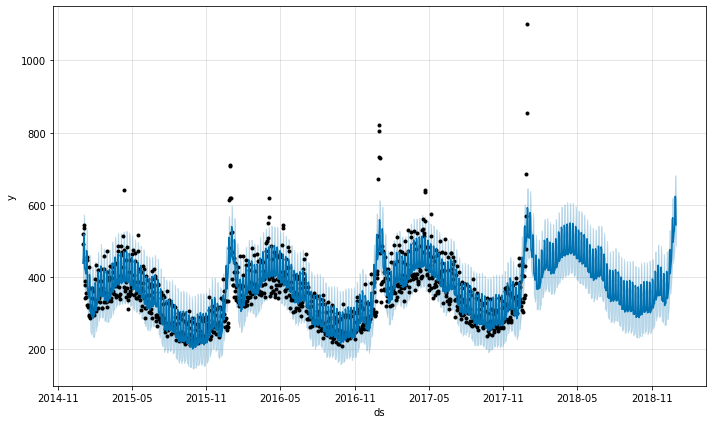

In [38]:
# Python
fig1 = m.plot(forecast)

In [39]:
df_compareError = forecast[['ds', 'yhat']]
df_compareError = pd.concat([df_compareError, df_pivot[['Finland_KaggleMart_Kaggle Hat']].reset_index()], axis=1)
                             

/apps/python3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:xlabel='date'>

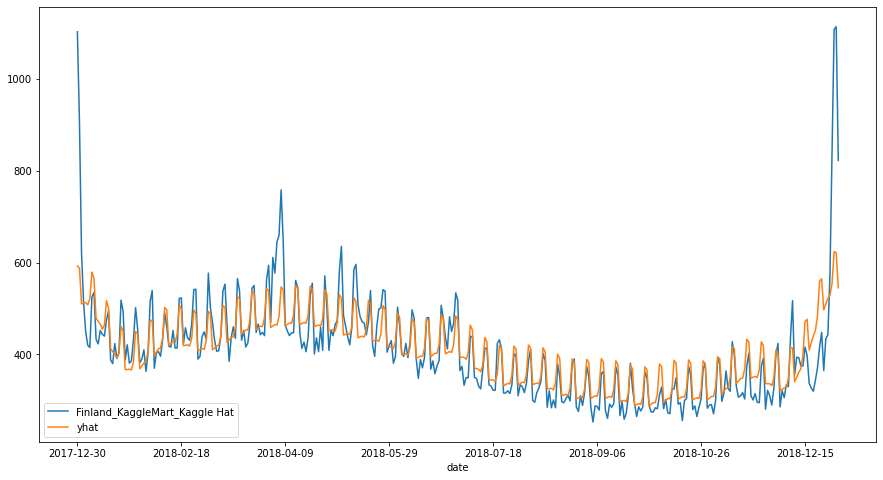

In [40]:
# fig = plt.figure()
df_compareError.iloc[-367:].plot(x='date', y=['Finland_KaggleMart_Kaggle Hat', 'yhat'], kind='line', figsize=(15,8))

### Forecast data for all 18 series

In [44]:
#Let's go ahead and just predict the sales of all 18 series, and generate a submission file for Kraggle.
def forecastFuture(input_df, productLine):
    # The productLine is country_store_product, e.g. "Finland_KaggleMart_Kaggle Hat"
    # We will use that column as targetLabe, and then predict the year 2018, and then check the error.
    m = Prophet()
    df_target = input_df[[productLine]].iloc[0:-366]
    df_target['ds'] = df_target.index
    df_target['y'] = df_target[productLine]
    df_target = df_target.reset_index()[['ds', 'y']]
    m.fit(df_target)
    future = m.make_future_dataframe(periods=366)
    print(future.tail())
    forecast = m.predict(future)
    return forecast

In [45]:
df_pivot.columns

Index(['Finland_KaggleMart_Kaggle Hat', 'Finland_KaggleMart_Kaggle Mug',
       'Finland_KaggleMart_Kaggle Sticker', 'Finland_KaggleRama_Kaggle Hat',
       'Finland_KaggleRama_Kaggle Mug', 'Finland_KaggleRama_Kaggle Sticker',
       'Norway_KaggleMart_Kaggle Hat', 'Norway_KaggleMart_Kaggle Mug',
       'Norway_KaggleMart_Kaggle Sticker', 'Norway_KaggleRama_Kaggle Hat',
       'Norway_KaggleRama_Kaggle Mug', 'Norway_KaggleRama_Kaggle Sticker',
       'Sweden_KaggleMart_Kaggle Hat', 'Sweden_KaggleMart_Kaggle Mug',
       'Sweden_KaggleMart_Kaggle Sticker', 'Sweden_KaggleRama_Kaggle Hat',
       'Sweden_KaggleRama_Kaggle Mug', 'Sweden_KaggleRama_Kaggle Sticker'],
      dtype='object')

In [48]:
#Loop through all the products and get prediction
forecastResultDict = {}
for prod in list(df_pivot.columns):
    print("Forecasting ", prod)
    forecastResultDict[prod] = forecastFuture(df_pivot, prod)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Forecasting  Finland_KaggleMart_Kaggle Hat
Initial log joint probability = -114.361
             ds
1456 2018-12-27
1457 2018-12-28
1458 2018-12-29
1459 2018-12-30
1460 2018-12-31
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2964.59   0.000279383        214.61      0.4796      0.4796      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     187       2967.75   0.000344489       228.088    3.27e-06       0.001      280  LS failed, Hessian reset 
     199       2968.22   0.000606788       71.1424           1           1      293   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     243        2968.5   0.000241492       112.144   3.319e-06       0.001      406  LS failed, Hessian reset 
     299       2968.63   4.18538e-06       33.8082           1           1      487   
    Iter      log prob        ||dx||      ||grad||       alph

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Forecasting  Finland_KaggleMart_Kaggle Mug
Initial log joint probability = -128.393
             ds
1456 2018-12-27
1457 2018-12-28
1458 2018-12-29
1459 2018-12-30
1460 2018-12-31
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3005.13   0.000181497       69.3018      0.2806      0.2806      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     111       3005.18   5.71577e-05       86.9848   9.482e-07       0.001      196  LS failed, Hessian reset 
     199       3007.35    0.00375729        111.23       0.114           1      311   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     200       3007.36   0.000297627       240.433   2.676e-06       0.001      358  LS failed, Hessian reset 
     238       3007.66   3.99327e-05        72.692    1.05e-06       0.001      449  LS failed, Hessian reset 
     266       3007.67   1.45667e-07 

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Forecasting  Finland_KaggleMart_Kaggle Sticker
Initial log joint probability = -102.401
             ds
1456 2018-12-27
1457 2018-12-28
1458 2018-12-29
1459 2018-12-30
1460 2018-12-31
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2878.09    0.00135992       113.855           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     173       2880.03   0.000300838       207.009   2.443e-06       0.001      315  LS failed, Hessian reset 
     199        2880.5    2.8626e-05       53.8717       0.115      0.8742      357   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     200        2880.5   7.71142e-05       65.0118   1.431e-06       0.001      398  LS failed, Hessian reset 
     212        2880.5   6.04403e-06       37.9674   1.169e-07       0.001      455  LS failed, Hessian reset 
     224        2880.5   7.89871e

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Forecasting  Finland_KaggleRama_Kaggle Hat
Initial log joint probability = -111.7
             ds
1456 2018-12-27
1457 2018-12-28
1458 2018-12-29
1459 2018-12-30
1460 2018-12-31
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        2891.1   0.000354103       75.8305           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     191       2893.83   2.60386e-05       58.3487   5.471e-07       0.001      291  LS failed, Hessian reset 
     199       2893.84   2.65032e-05       37.7901       0.734       0.734      303   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     216       2893.85   7.44448e-05       78.5687    1.03e-06       0.001      365  LS failed, Hessian reset 
     272       2893.95   0.000167015       127.767   1.986e-06       0.001      487  LS failed, Hessian reset 
     289          2894   1.60345e-05   

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Forecasting  Finland_KaggleRama_Kaggle Mug
Initial log joint probability = -128.336
             ds
1456 2018-12-27
1457 2018-12-28
1458 2018-12-29
1459 2018-12-30
1460 2018-12-31
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3008.03   0.000939182       132.216      0.6473      0.6473      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     185       3011.01   0.000142628        142.96   1.769e-06       0.001      286  LS failed, Hessian reset 
     199       3011.16   0.000100058       91.1034       0.435       0.435      308   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     225       3011.38   0.000115319        85.698   2.607e-06       0.001      381  LS failed, Hessian reset 
     299       3011.56   4.11543e-05       52.7745           1           1      480   
    Iter      log prob        ||dx||      ||grad||       alph

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Forecasting  Finland_KaggleRama_Kaggle Sticker
Initial log joint probability = -116.804
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2911.15   0.000670078       133.834           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     142       2913.09   0.000197654        187.07   1.033e-06       0.001      225  LS failed, Hessian reset 
     199       2913.45   2.06963e-05       76.5134      0.1498      0.1498      294   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     213       2913.55   0.000443352       206.885   5.279e-06       0.001      366  LS failed, Hessian reset 
     241       2913.59   2.03983e-05       47.3735   2.983e-07       0.001      448  LS failed, Hessian reset 
     260       2913.59   6.33533e-06       41.8132   1.133e-07       0.001      516  LS failed, Hessian reset 
     273       291

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Forecasting  Norway_KaggleMart_Kaggle Hat
Initial log joint probability = -115.897
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2850.73   0.000674411       80.8772       2.154      0.2154      138   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2853.96   0.000987532       89.3866      0.7401      0.7401      265   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     204       2854.02   0.000114674       100.363   7.264e-07       0.001      316  LS failed, Hessian reset 
     299       2854.14    0.00336491       79.8047           1           1      447   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     318       2854.24    0.00032294       100.801   3.881e-06       0.001      504  LS failed, Hessian reset 
     399       2854.32   1.20217e-06        53.383      0.3056    

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Forecasting  Norway_KaggleMart_Kaggle Mug
Initial log joint probability = -122.04
             ds
1456 2018-12-27
1457 2018-12-28
1458 2018-12-29
1459 2018-12-30
1460 2018-12-31
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2905.73    0.00306156       103.137      0.2734           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2909.81   5.89319e-06       62.5139      0.3034     0.03034      265   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     210       2909.85   0.000125976       124.909   9.116e-07       0.001      324  LS failed, Hessian reset 
     263       2909.96   0.000208057       149.052   2.772e-06       0.001      462  LS failed, Hessian reset 
     299       2910.01   1.42078e-05       66.1047       0.732           1      512   
    Iter      log prob        ||dx||      ||grad||       alpha 

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Forecasting  Norway_KaggleMart_Kaggle Sticker
Initial log joint probability = -103.003
             ds
1456 2018-12-27
1457 2018-12-28
1458 2018-12-29
1459 2018-12-30
1460 2018-12-31
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2803.98    0.00633629       96.5647       0.985       0.985      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     128       2805.92   0.000151283       122.315   1.522e-06       0.001      194  LS failed, Hessian reset 
     184       2806.31   4.41961e-05       61.5115   5.868e-07       0.001      298  LS failed, Hessian reset 
     199       2806.31   2.46946e-06       52.1838       0.932       0.932      315   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     211       2806.31   3.93655e-07       65.2266           1           1      336   
Optimization terminated normally: 
  Convergence detected:

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Forecasting  Norway_KaggleRama_Kaggle Hat
Initial log joint probability = -107.958
             ds
1456 2018-12-27
1457 2018-12-28
1458 2018-12-29
1459 2018-12-30
1460 2018-12-31
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2837.65    0.00383755       173.751      0.4008      0.4008      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     174       2840.91   0.000245313       191.346   1.444e-06       0.001      249  LS failed, Hessian reset 
     199       2841.37    6.0074e-05        77.249           1           1      279   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2841.42   3.23513e-05       71.9414           1           1      414   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     351       2841.46   8.16762e-08       69.2075       0.268           1      4

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Forecasting  Norway_KaggleRama_Kaggle Mug
Initial log joint probability = -130.471
             ds
1456 2018-12-27
1457 2018-12-28
1458 2018-12-29
1459 2018-12-30
1460 2018-12-31
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      53       2909.92   7.28389e-05       76.5642   1.035e-06       0.001      116  LS failed, Hessian reset 
      99        2910.8    0.00495701       178.346      0.1835           1      170   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     138       2912.38   9.72997e-05       92.7573   7.853e-07       0.001      265  LS failed, Hessian reset 
     176       2912.87   0.000148686       126.694   2.276e-06       0.001      357  LS failed, Hessian reset 
     199        2912.9   0.000615345       96.2972      0.9512      0.9512      386   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     221       2913.04   0.000114805  

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Forecasting  Norway_KaggleRama_Kaggle Sticker
Initial log joint probability = -99.1491
             ds
1456 2018-12-27
1457 2018-12-28
1458 2018-12-29
1459 2018-12-30
1460 2018-12-31
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2910.66    0.00110195       491.626      0.3821      0.3821      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     137       2912.51    0.00020762       168.113   1.688e-06       0.001      211  LS failed, Hessian reset 
     199       2913.31    0.00105161       149.734           1           1      287   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     205       2913.36   8.73034e-05       79.1182   6.466e-07       0.001      343  LS failed, Hessian reset 
     270       2914.31   0.000134274       127.335   7.245e-07       0.001      465  LS failed, Hessian reset 
     299       2914.83   0.0002635

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Forecasting  Sweden_KaggleMart_Kaggle Hat
Initial log joint probability = -112.456
             ds
1456 2018-12-27
1457 2018-12-28
1458 2018-12-29
1459 2018-12-30
1460 2018-12-31
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2854.23    0.00143972        64.865           1           1      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     161       2856.37   0.000181899       154.049   9.151e-07       0.001      254  LS failed, Hessian reset 
     178       2856.52   9.62082e-05        46.318   1.789e-06       0.001      304  LS failed, Hessian reset 
     199       2856.53   9.53284e-06         57.97      0.3333      0.8408      337   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     216       2856.59   0.000101916       93.0822   7.363e-07       0.001      396  LS failed, Hessian reset 
     251        2856.6   2.14277e-05  

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Forecasting  Sweden_KaggleMart_Kaggle Mug
Initial log joint probability = -138.724
             ds
1456 2018-12-27
1457 2018-12-28
1458 2018-12-29
1459 2018-12-30
1460 2018-12-31    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2883.07     0.0007195       108.842           1           1      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2884.63    0.00104697       51.4344      0.6682      0.6682      260   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     206       2884.66   0.000238396       48.1384   3.828e-06       0.001      311  LS failed, Hessian reset 
     269       2884.83   7.16383e-05       87.2725   1.322e-06       0.001      445  LS failed, Hessian reset 
     299       2884.84   1.72003e-05       52.1134           1           1      493   
    Iter      log prob        ||dx||      ||grad||       alpha 

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Forecasting  Sweden_KaggleMart_Kaggle Sticker
Initial log joint probability = -109.275
             ds
1456 2018-12-27
1457 2018-12-28
1458 2018-12-29
1459 2018-12-30
1460 2018-12-31    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2936.09   0.000836823       186.299           1           1      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2937.65   0.000285369       91.9756      0.8592      0.8592      259   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     254       2938.12    0.00016726       160.061    1.63e-06       0.001      383  LS failed, Hessian reset 
     299       2938.19   0.000250699       70.4255           1           1      446   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     346       2938.39   0.000268104       47.2404   3.387e-06       0.001    

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Forecasting  Sweden_KaggleRama_Kaggle Hat
Initial log joint probability = -119.193
             ds
1456 2018-12-27
1457 2018-12-28
1458 2018-12-29
1459 2018-12-30
1460 2018-12-31
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      61       2851.84   0.000192697       123.797   3.627e-06       0.001      125  LS failed, Hessian reset 
      99       2852.35    0.00376868       71.5118       0.247           1      168   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2854.39   0.000831619       84.6332      0.8804      0.8804      292   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2854.44   2.41258e-05       65.0897           1           1      435   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     318       2854.46    0.00050492       95.7678   5.397e-06       0.001      4

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Forecasting  Sweden_KaggleRama_Kaggle Mug
Initial log joint probability = -132.099
             ds
1456 2018-12-27
1457 2018-12-28
1458 2018-12-29
1459 2018-12-30
1460 2018-12-31
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3020.31     0.0025636       83.7713           1           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     123       3020.79   6.30698e-05       77.3183   5.819e-07       0.001      199  LS failed, Hessian reset 
     132       3020.84   0.000270171       106.551   5.073e-06       0.001      245  LS failed, Hessian reset 
     199       3021.16   0.000261138       124.117      0.8502      0.8502      336   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     210       3021.28   0.000237536        72.589   3.997e-06       0.001      387  LS failed, Hessian reset 
     299       3022.15   0.000958352  

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Forecasting  Sweden_KaggleRama_Kaggle Sticker
Initial log joint probability = -116.351
             ds
1456 2018-12-27
1457 2018-12-28
1458 2018-12-29
1459 2018-12-30
1460 2018-12-31
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2994.66    0.00332856       175.164          10           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     142       2995.22   0.000108382       126.148   9.326e-07       0.001      240  LS failed, Hessian reset 
     199       2995.56    0.00795104       136.738      0.3086           1      328   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     226       2996.17   9.89076e-05       123.688   8.716e-07       0.001      402  LS failed, Hessian reset 
     249       2996.41   0.000270513       161.112   3.312e-06       0.001      474  LS failed, Hessian reset 
     299       2996.49   5.34888e-

In [50]:
forecastResultDict.keys()

dict_keys(['Finland_KaggleMart_Kaggle Hat', 'Finland_KaggleMart_Kaggle Mug', 'Finland_KaggleMart_Kaggle Sticker', 'Finland_KaggleRama_Kaggle Hat', 'Finland_KaggleRama_Kaggle Mug', 'Finland_KaggleRama_Kaggle Sticker', 'Norway_KaggleMart_Kaggle Hat', 'Norway_KaggleMart_Kaggle Mug', 'Norway_KaggleMart_Kaggle Sticker', 'Norway_KaggleRama_Kaggle Hat', 'Norway_KaggleRama_Kaggle Mug', 'Norway_KaggleRama_Kaggle Sticker', 'Sweden_KaggleMart_Kaggle Hat', 'Sweden_KaggleMart_Kaggle Mug', 'Sweden_KaggleMart_Kaggle Sticker', 'Sweden_KaggleRama_Kaggle Hat', 'Sweden_KaggleRama_Kaggle Mug', 'Sweden_KaggleRama_Kaggle Sticker'])

In [51]:
# Let's visualize the prediction and see how well it is doing, for year 2018.
# We'll chart one country per row, one store at a time
print('Countries: ', countryList)
print('Products: ', productList)
print('Stores: ', storeList)

Countries:  ['Finland', 'Norway', 'Sweden']
Products:  ['Kaggle Mug', 'Kaggle Hat', 'Kaggle Sticker']
Stores:  ['KaggleMart', 'KaggleRama']


In [52]:
df_pivot.head()

,Finland_KaggleMart_Kaggle Hat,Finland_KaggleMart_Kaggle Mug,Finland_KaggleMart_Kaggle Sticker,Finland_KaggleRama_Kaggle Hat,Finland_KaggleRama_Kaggle Mug,Finland_KaggleRama_Kaggle Sticker,Norway_KaggleMart_Kaggle Hat,Norway_KaggleMart_Kaggle Mug,Norway_KaggleMart_Kaggle Sticker,Norway_KaggleRama_Kaggle Hat,Norway_KaggleRama_Kaggle Mug,Norway_KaggleRama_Kaggle Sticker,Sweden_KaggleMart_Kaggle Hat,Sweden_KaggleMart_Kaggle Mug,Sweden_KaggleMart_Kaggle Sticker,Sweden_KaggleRama_Kaggle Hat,Sweden_KaggleRama_Kaggle Mug,Sweden_KaggleRama_Kaggle Sticker
date,,,,,,,,,,,,,,,,,,
2015-01-01,520,329,146,911,572,283,906,526,250,1461,1005,395,624,440,175,1195,706,324
2015-01-02,493,318,127,794,544,249,845,538,237,1446,949,415,572,384,155,986,653,293
2015-01-03,535,360,141,843,579,265,930,614,254,1631,1029,451,630,420,173,1167,734,319
2015-01-04,544,332,125,873,582,245,889,589,255,1540,957,455,697,406,169,1112,657,300
2015-01-05,378,243,102,668,423,187,671,435,184,1126,739,310,442,298,127,796,512,227


### Visualizing training results for 2018

In [71]:
def plotChartsForStore(store):
    rowCount = len(productList)
    colCount = len(countryList)
    fig, axs = plt.subplots(rowCount, colCount, figsize=(30,30))
    fig.subplots_adjust(hspace=0.4,wspace=0.2)
    for i in range(0,rowCount):
        for j in range(0,colCount):
            #Grab prediction from forecastResultDict, and concat with actual
            currProd = countryList[j] + '_' + store + '_' + productList[i]
            print("Generating chart for: ", currProd)
            forecast = forecastResultDict[currProd]
            df_compareError = forecast[['ds', 'yhat']]
            df_compareError = pd.concat([df_compareError, df_pivot[[currProd]].reset_index()], axis=1)
            df_compareError['date'] = pd.to_datetime(df_compareError['date'])
            # df_compareError.plot(x='date', y=[currProd, 'yhat'], kind='line', figsize=(15,8))
            axs[i, j].plot(df_compareError['date'], df_compareError[currProd], label="actual")
            axs[i, j].plot(df_compareError['date'], df_compareError['yhat'], label="forecast")
            axs[i, j].tick_params(labelrotation=90)
            axs[i, j].set_xlabel("Date", fontsize=10)
            axs[i, j].set_ylabel("Sales", fontsize=10)                         
            axs[i, j].set_yticks(np.arange(0,df_compareError[currProd].max()*1.3,100))
            axs[i, j].legend()
            axs[i, j].set_title(currProd)        

            # actual_df = df_pivot[countryList[j] + '_' + store + '_' + productList[i]                             
            # axs[i, j].plot(df["ID"],df["Column A"], label = "Stuff")
            # axs[i, j].tick_params(labelrotation=90)
            # 
            # axs[i, j].set_xticks(np.arange(0,26,1))
            # 
            # axs[i, j].grid(color='gray', linestyle='-', linewidth=0.3)

    plt.show()

Generating chart for:  Finland_KaggleMart_Kaggle Mug
Generating chart for:  Norway_KaggleMart_Kaggle Mug
Generating chart for:  Sweden_KaggleMart_Kaggle Mug
Generating chart for:  Finland_KaggleMart_Kaggle Hat
Generating chart for:  Norway_KaggleMart_Kaggle Hat
Generating chart for:  Sweden_KaggleMart_Kaggle Hat
Generating chart for:  Finland_KaggleMart_Kaggle Sticker
Generating chart for:  Norway_KaggleMart_Kaggle Sticker
Generating chart for:  Sweden_KaggleMart_Kaggle Sticker


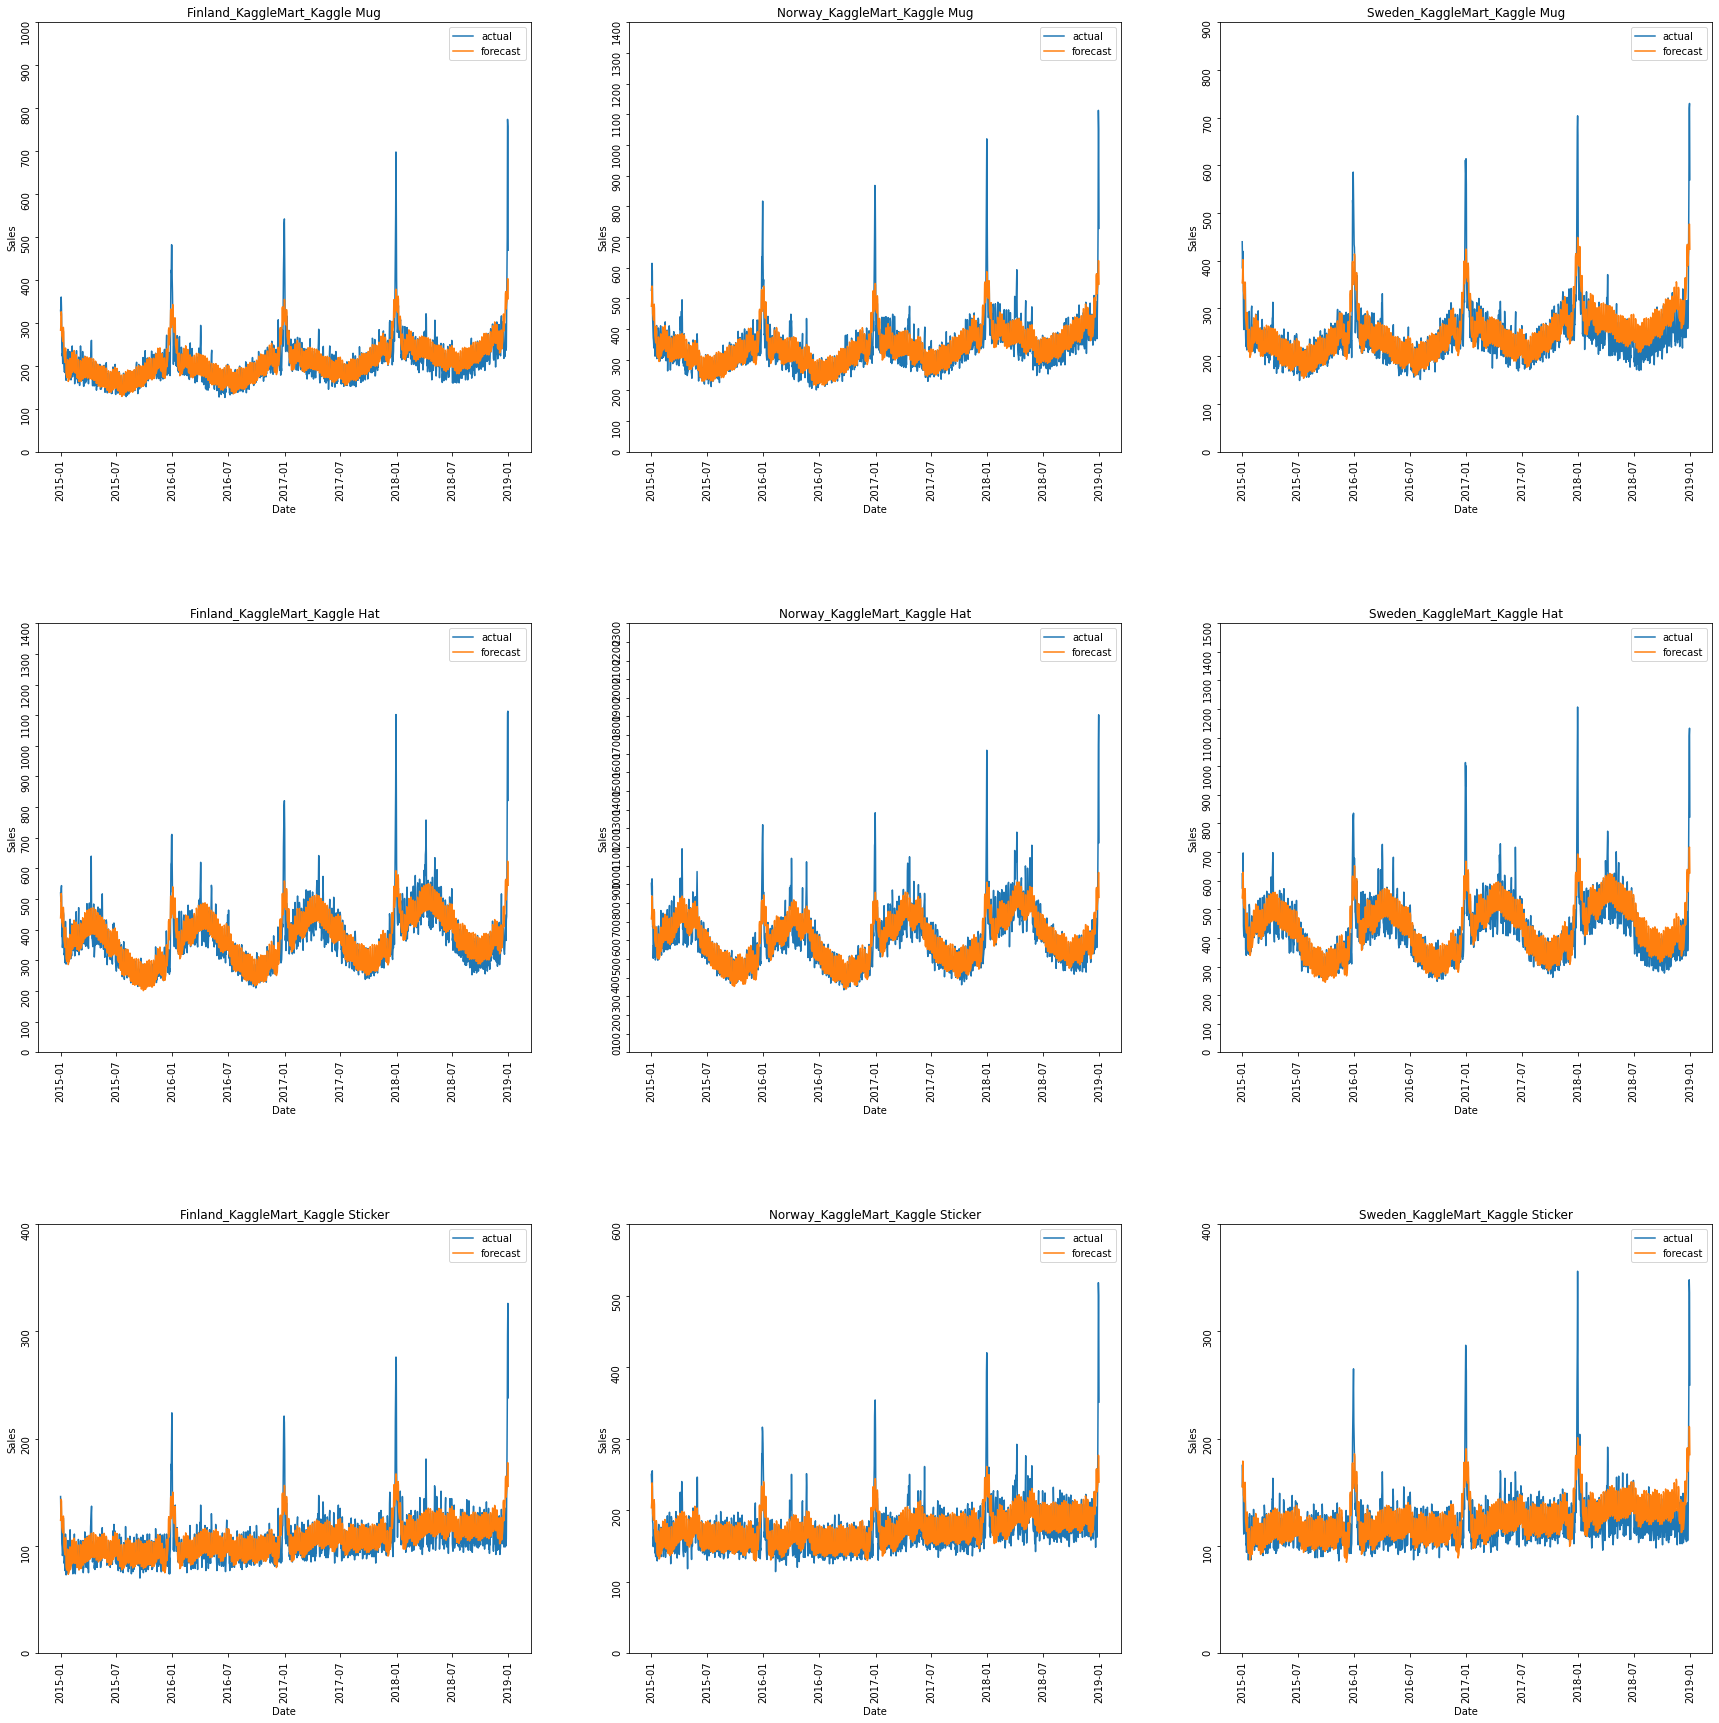

In [72]:
plotChartsForStore('KaggleMart')



Generating chart for:  Finland_KaggleRama_Kaggle Mug
Generating chart for:  Norway_KaggleRama_Kaggle Mug
Generating chart for:  Sweden_KaggleRama_Kaggle Mug
Generating chart for:  Finland_KaggleRama_Kaggle Hat
Generating chart for:  Norway_KaggleRama_Kaggle Hat
Generating chart for:  Sweden_KaggleRama_Kaggle Hat
Generating chart for:  Finland_KaggleRama_Kaggle Sticker
Generating chart for:  Norway_KaggleRama_Kaggle Sticker
Generating chart for:  Sweden_KaggleRama_Kaggle Sticker


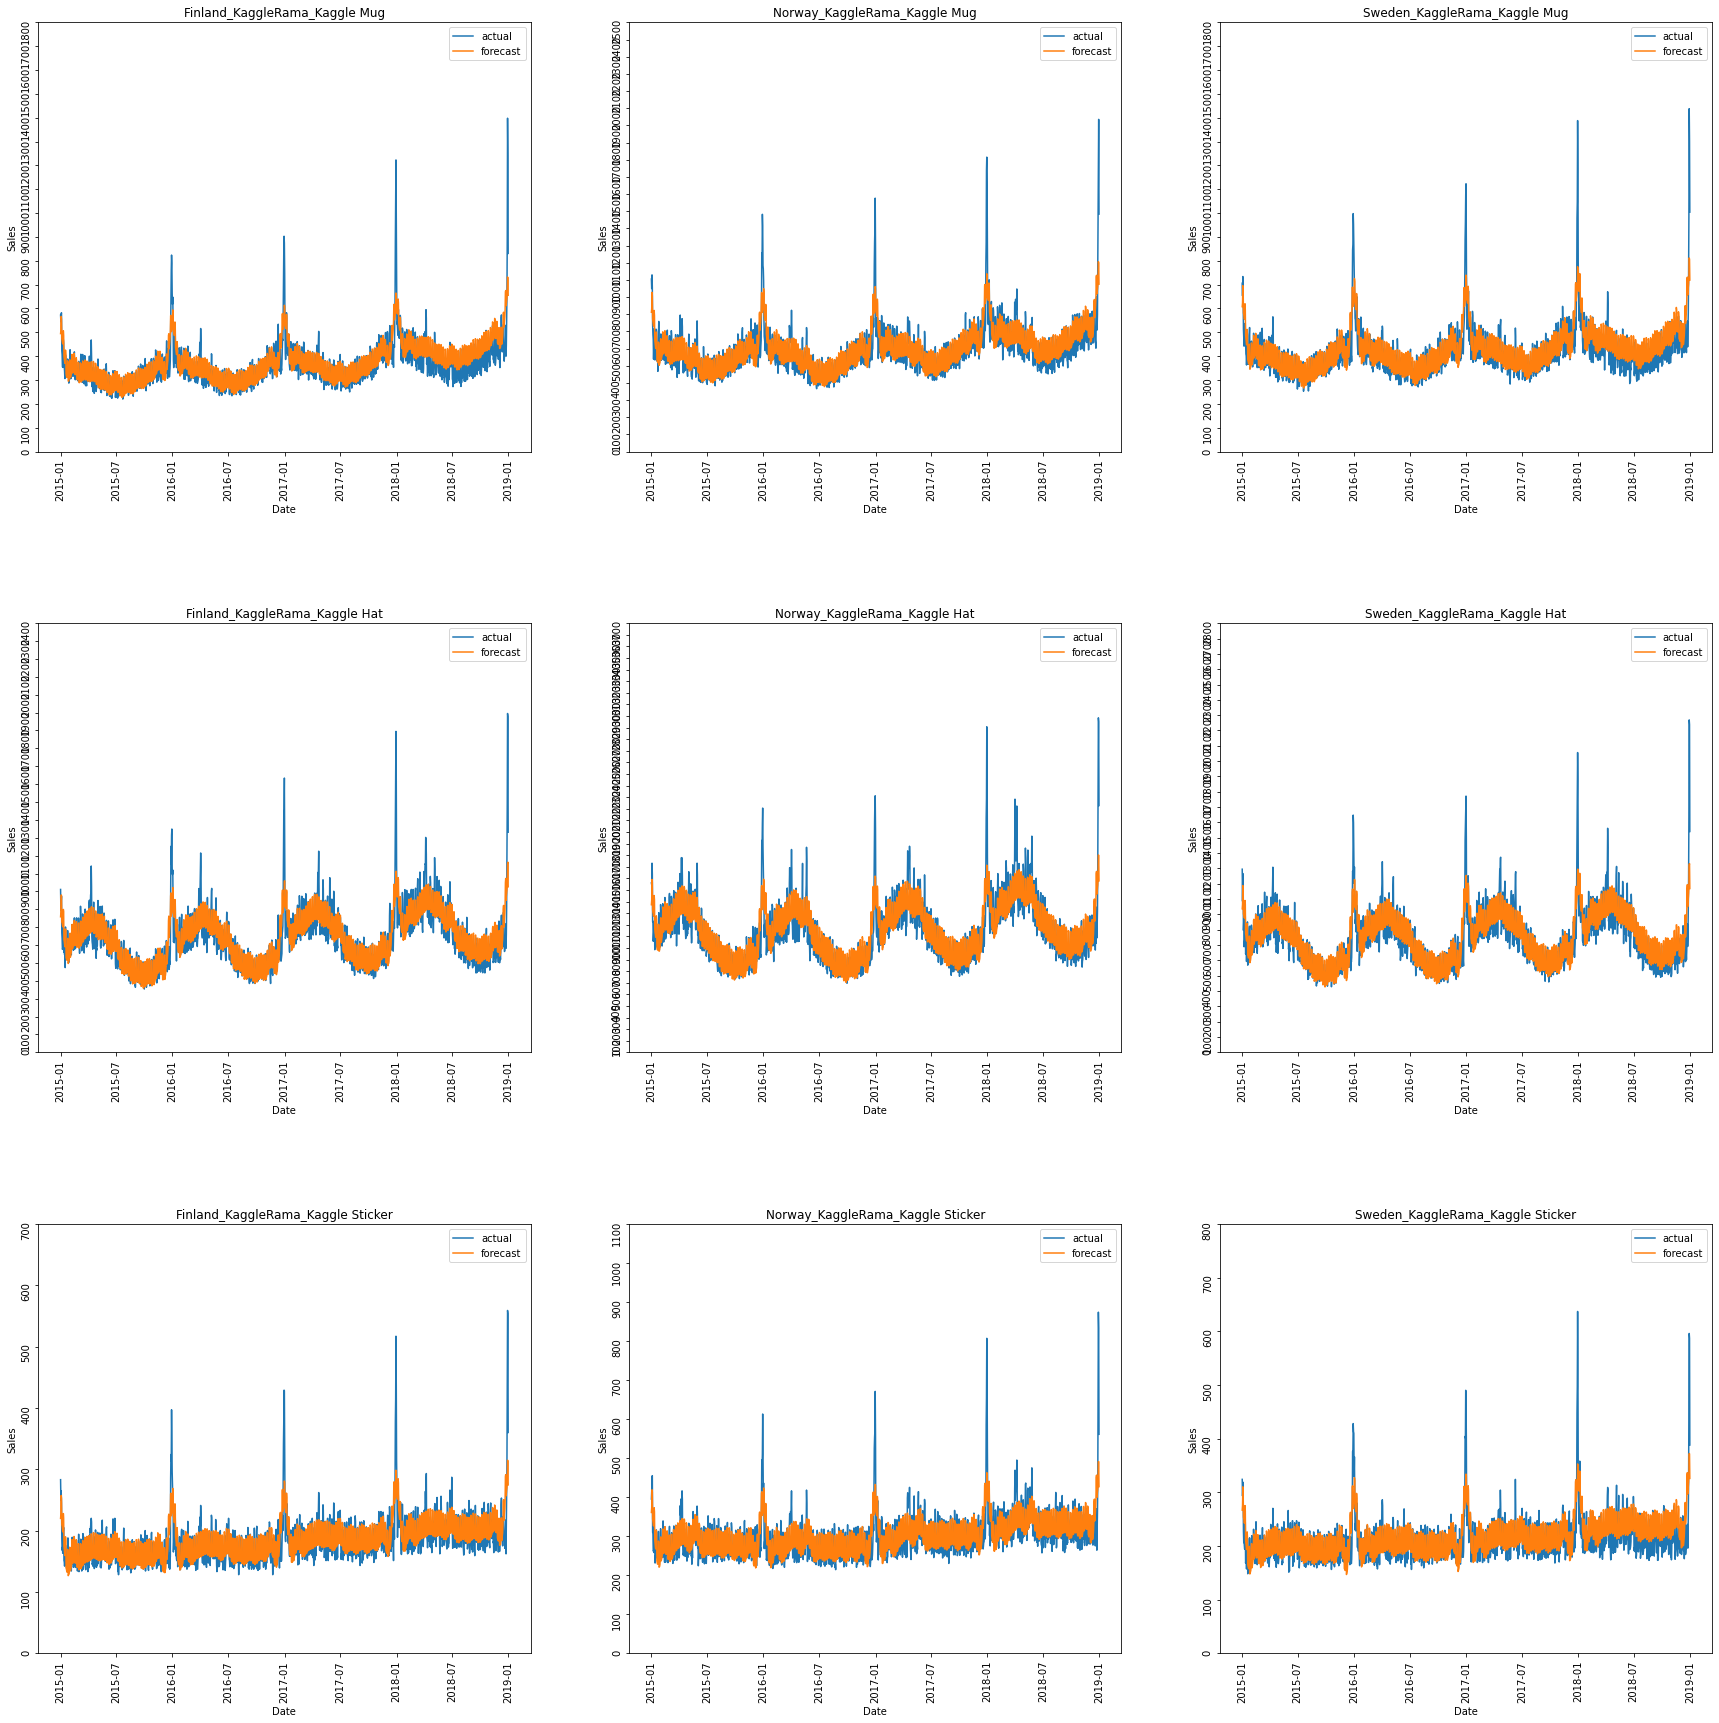

In [73]:
plotChartsForStore('KaggleRama')


### Retrain model using all data, and then predict sales for 2019 as the test required

In [74]:
def trainAllData(input_df, productLine):
    # The productLine is country_store_product, e.g. "Finland_KaggleMart_Kaggle Hat"
    # We will use that column as targetLabe, and then predict the year 2018, and then check the error.
    m = Prophet()
    df_target = input_df[[productLine]]
    df_target['ds'] = df_target.index
    df_target['y'] = df_target[productLine]
    df_target = df_target.reset_index()[['ds', 'y']]
    m.fit(df_target)
    future = m.make_future_dataframe(periods=365)
    print(future.tail())
    forecast = m.predict(future)
    return forecast

In [75]:
compSubResultDict = {}
for prod in list(df_pivot.columns):
    print("Preparing test submission for  ", prod)
    compSubResultDict[prod] = trainAllData(df_pivot, prod)

/apps/python3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/apps/python3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Preparing test submission for   Finland_KaggleMart_Kaggle Hat
Initial log joint probability = -66.2666
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        3834.3   0.000739764       310.035       0.334       0.334      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     129       3834.73   0.000119171        95.771   4.254e-07       0.001      216  LS failed, Hessian reset 
     199       3834.94   0.000414546       83.3009           1           1      312   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     212       3835.02   0.000131738       144.655   1.683e-06       0.001      390  LS failed, Hessian reset 
     299       3835.11   2.19067e-05       69.3461           1           1      504   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     309       3835.11   4.59564e-06       47.

/apps/python3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/apps/python3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Preparing test submission for   Finland_KaggleMart_Kaggle Mug
Initial log joint probability = -52.1817
             ds
1821 2019-12-27
1822 2019-12-28
1823 2019-12-29
1824 2019-12-30
1825 2019-12-31
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      80       4011.77    0.00024082       98.0078   3.258e-06       0.001      152  LS failed, Hessian reset 
      99       4011.79   1.39695e-05       64.6543           1           1      178   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     151       4012.06   0.000154662       201.335   1.076e-06       0.001      316  LS failed, Hessian reset 
     197       4012.15   3.37794e-05       78.1827   5.458e-07       0.001      423  LS failed, Hessian reset 
     199       4012.15   6.68332e-06       78.5801      0.3776           1      427   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     219       401

/apps/python3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/apps/python3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Preparing test submission for   Finland_KaggleMart_Kaggle Sticker
Initial log joint probability = -61.3699
             ds
1821 2019-12-27
1822 2019-12-28
1823 2019-12-29
1824 2019-12-30
1825 2019-12-31
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      72       3940.45   0.000181063       155.418   2.842e-06       0.001      130  LS failed, Hessian reset 
      99       3940.57   8.56399e-05       85.1621     0.03457           1      168   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        3941.1     0.0011295       85.6968      0.4786      0.4786      289   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     278       3941.43   8.78228e-05       118.354   1.303e-06       0.001      435  LS failed, Hessian reset 
     299       3941.45   6.03882e-05       57.9222      0.4341      0.4341      459   
    Iter      log prob        ||dx||  

/apps/python3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/apps/python3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Preparing test submission for   Finland_KaggleRama_Kaggle Hat
Initial log joint probability = -47.9082
             ds
1821 2019-12-27
1822 2019-12-28
1823 2019-12-29
1824 2019-12-30
1825 2019-12-31    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      98       3829.34   7.94224e-05        95.642    7.68e-07       0.001      185  LS failed, Hessian reset 
      99       3829.35   3.83324e-05        73.248           1           1      186   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     137       3829.42   0.000107446       97.5734    1.91e-06       0.001      263  LS failed, Hessian reset 
     199       3829.45   9.45944e-05       66.5173           1           1      349   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     206       3829.45   3.32206e-05       54.2788   4.387e-07       0.001      397  LS failed, Hessian reset 
     269       3829

/apps/python3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/apps/python3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Preparing test submission for   Finland_KaggleRama_Kaggle Mug
Initial log joint probability = -50.3628
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        4063.4   0.000246109       81.3044           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     140       4063.69   5.31043e-05       92.6994   5.033e-07       0.001      226  LS failed, Hessian reset 
     199       4063.79   5.61064e-06       61.9621      0.8608      0.8608      303   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     238        4063.8   1.20444e-07       44.4443      0.1962      0.3455      361   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
             ds
1821 2019-12-27
1822 2019-12-28
1823 2019-12-29
1824 2019-12-30
1825 2019-12-31


/apps/python3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/apps/python3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Preparing test submission for   Finland_KaggleRama_Kaggle Sticker
Initial log joint probability = -51.774
             ds
1821 2019-12-27
1822 2019-12-28
1823 2019-12-29
1824 2019-12-30
1825 2019-12-31
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3880.53   0.000738344       80.7192       2.124      0.3527      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     109       3880.56   7.76185e-05       113.248   1.034e-06       0.001      175  LS failed, Hessian reset 
     159       3880.69   8.24644e-05       107.777   5.612e-07       0.001      292  LS failed, Hessian reset 
     199       3880.77   4.51947e-05       82.9578     0.04869           1      343   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     201       3880.77   8.43396e-05       84.4229   1.133e-06       0.001      384  LS failed, Hessian reset 
     233       

/apps/python3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/apps/python3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Preparing test submission for   Norway_KaggleMart_Kaggle Hat
Initial log joint probability = -47.3773
             ds
1821 2019-12-27
1822 2019-12-28
1823 2019-12-29
1824 2019-12-30
1825 2019-12-31    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        3862.9   0.000694983       74.9401           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3864.37   0.000365082       100.669      0.6432      0.6432      256   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     244       3864.64   8.12698e-05       116.409   8.879e-07       0.001      356  LS failed, Hessian reset 
     299       3864.76    6.3412e-05       76.7538           1           1      434   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     311       3864.78   9.63022e-05       111.784   1.367e-06 

/apps/python3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/apps/python3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Preparing test submission for   Norway_KaggleMart_Kaggle Mug
Initial log joint probability = -57.0221
             ds
1821 2019-12-27
1822 2019-12-28
1823 2019-12-29
1824 2019-12-30
1825 2019-12-31    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3930.96      0.001859       72.8723       0.475           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     101       3930.97    0.00193062        205.34   3.127e-05       0.001      170  LS failed, Hessian reset 
     199       3931.49    5.0891e-05       66.4805      0.3578      0.3578      305   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     216       3931.61   5.69123e-05       81.2487   6.311e-07       0.001      365  LS failed, Hessian reset 
     277       3931.78   2.36913e-07       63.2841       0.477       0.477      448   
Optimization terminated normally: 
  Converg

/apps/python3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/apps/python3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Preparing test submission for   Norway_KaggleMart_Kaggle Sticker
Initial log joint probability = -52.4728
             ds
1821 2019-12-27
1822 2019-12-28
1823 2019-12-29
1824 2019-12-30
1825 2019-12-31
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3908.23    0.00520777       160.985      0.9167      0.9167      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     120       3908.66   4.97465e-05       68.7377    5.29e-07       0.001      197  LS failed, Hessian reset 
     137       3908.71    0.00029845        182.88   4.008e-06       0.001      259  LS failed, Hessian reset 
     168       3908.73   5.74722e-05       88.0855   7.493e-07       0.001      348  LS failed, Hessian reset 
     199       3908.73   1.18468e-06       52.6544      0.3188           1      393   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     229       

/apps/python3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/apps/python3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Preparing test submission for   Norway_KaggleRama_Kaggle Hat
Initial log joint probability = -61.2876
             ds
1821 2019-12-27
1822 2019-12-28
1823 2019-12-29
1824 2019-12-30
1825 2019-12-31
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        3730.6    0.00612588       161.822           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     131       3731.24   0.000528474       148.388   6.827e-06       0.001      185  LS failed, Hessian reset 
     198       3731.85   0.000123573       117.888   6.214e-07       0.001      305  LS failed, Hessian reset 
     199       3731.87   0.000623146       107.972          10           1      307   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     242       3731.97   9.13607e-05       79.6165   1.722e-06       0.001      405  LS failed, Hessian reset 
     257       3731

/apps/python3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/apps/python3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Preparing test submission for   Norway_KaggleRama_Kaggle Mug
Initial log joint probability = -79.1919
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      66       3952.99   8.99993e-05       123.438   8.193e-07       0.001      118  LS failed, Hessian reset 
      99       3953.24   0.000148148        57.743       0.284           1      168   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     127       3953.54   0.000133151       136.655   1.417e-06       0.001      239  LS failed, Hessian reset 
     199       3953.67   0.000227688        78.246      0.3995      0.3995      342   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     233       3953.81   0.000112234       128.576   1.535e-06       0.001      426  LS failed, Hessian reset 
     277        3953.9   1.50677e-05       67.7472   2.164e-07       0.001      526  LS failed, Hessian reset 
    

/apps/python3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/apps/python3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Preparing test submission for   Norway_KaggleRama_Kaggle Sticker
Initial log joint probability = -37.6585
             ds
1821 2019-12-27
1822 2019-12-28
1823 2019-12-29
1824 2019-12-30
1825 2019-12-31
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3889.85    0.00197559       181.344       1.511      0.1511      140   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        3890.7   7.63272e-05       60.5289           1           1      260   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     285       3890.95   0.000253188       213.431   3.404e-06       0.001      432  LS failed, Hessian reset 
     299       3890.98    2.2374e-05       57.0171       0.179       0.762      449   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     315       3890.98   2.53083e-05       74.2424   3.079

/apps/python3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/apps/python3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Preparing test submission for   Sweden_KaggleMart_Kaggle Hat
Initial log joint probability = -55.7428
             ds
1821 2019-12-27
1822 2019-12-28
1823 2019-12-29
1824 2019-12-30
1825 2019-12-31
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3779.07   0.000373986       84.9371      0.3467           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     147       3779.24    5.1449e-06       70.6956   8.315e-08       0.001      244  LS failed, Hessian reset 
     158       3779.25   3.06241e-07        54.735           1           1      262   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/apps/python3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/apps/python3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Preparing test submission for   Sweden_KaggleMart_Kaggle Mug
Initial log joint probability = -106.878
             ds
1821 2019-12-27
1822 2019-12-28
1823 2019-12-29
1824 2019-12-30
1825 2019-12-31
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3832.34   0.000203085       87.8545       0.489       0.489      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     147        3832.8   0.000168627       201.594   1.708e-06       0.001      229  LS failed, Hessian reset 
     195        3832.9   0.000121385       88.5169   1.767e-06       0.001      323  LS failed, Hessian reset 
     199        3832.9   1.48131e-05       68.4386      0.1989      0.7254      328   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     225        3832.9   3.49367e-07       55.6553      0.7479      0.7479      366   
Optimization terminated normally: 
  Conver

/apps/python3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/apps/python3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Preparing test submission for   Sweden_KaggleMart_Kaggle Sticker
Initial log joint probability = -56.4268
             ds
1821 2019-12-27
1822 2019-12-28
1823 2019-12-29
1824 2019-12-30
1825 2019-12-31
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3848.16   9.45248e-05       121.519      0.1677           1      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     182       3848.56   0.000191306       204.003     1.5e-06       0.001      277  LS failed, Hessian reset 
     199       3848.63   2.82718e-05       52.1922           1           1      302   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     208       3848.64   3.59374e-05       58.5016   4.535e-07       0.001      343  LS failed, Hessian reset 
     293       3848.78   0.000176837       151.229   2.561e-06       0.001      504  LS failed, Hessian reset 
     299       

/apps/python3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/apps/python3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Preparing test submission for   Sweden_KaggleRama_Kaggle Hat
Initial log joint probability = -61.5324
             ds
1821 2019-12-27
1822 2019-12-28
1823 2019-12-29
1824 2019-12-30
1825 2019-12-31
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3851.23   0.000818611       88.8455           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     101       3851.24   6.33941e-05        100.76   6.772e-07       0.001      185  LS failed, Hessian reset 
     122       3851.25   7.40183e-05       75.1606   1.147e-06       0.001      247  LS failed, Hessian reset 
     168       3851.26   1.75499e-06       73.1761   3.012e-08       0.001      377  LS failed, Hessian reset 
     199       3851.26   6.83386e-07       57.6234      0.3826           1      422   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     207       3851

/apps/python3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/apps/python3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Preparing test submission for   Sweden_KaggleRama_Kaggle Mug
Initial log joint probability = -76.8898
             ds
1821 2019-12-27
1822 2019-12-28
1823 2019-12-29
1824 2019-12-30
1825 2019-12-31
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3966.49   0.000760289       85.9326           1           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     114       3966.58   7.77958e-05       82.8781    1.04e-06       0.001      185  LS failed, Hessian reset 
     193       3966.63   5.28496e-05       63.2168   7.022e-07       0.001      338  LS failed, Hessian reset 
     199       3966.64   0.000246957       92.7627           1           1      345   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     263       3966.66   3.01066e-05       67.5343   5.277e-07       0.001      471  LS failed, Hessian reset 
     288       3966

/apps/python3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/apps/python3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Preparing test submission for   Sweden_KaggleRama_Kaggle Sticker
Initial log joint probability = -44.4642
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3917.79      0.002089       102.959      0.4745           1      138   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     100        3917.8   0.000341361       207.279   3.315e-06       0.001      176  LS failed, Hessian reset 
     133       3917.82   2.26227e-05       62.3927   5.141e-07       0.001      261  LS failed, Hessian reset 
     181       3917.84   0.000204745       45.9869   2.118e-06       0.001      380  LS failed, Hessian reset 
     199       3917.84   3.41075e-07       56.7954      0.2756      0.2756      408   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     231       3917.85   1.94601e-05       40.9449   2.798e-07       0.001      500  LS failed, Hessian reset 


### Visualizing 2019 forecasts

/apps/python3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:xlabel='date'>

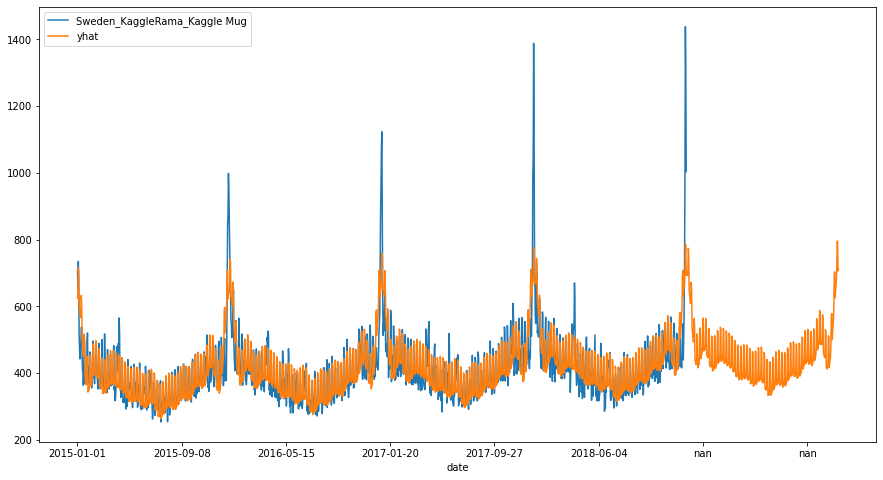

In [83]:
# Visualize one product just for sanity check
forecast = compSubResultDict['Sweden_KaggleRama_Kaggle Mug']
df_compareError = forecast[['ds', 'yhat']]
df_compareError = pd.concat([df_compareError, df_pivot[['Sweden_KaggleRama_Kaggle Mug']].reset_index()], axis=1)
df_compareError.plot(x='date', y=['Sweden_KaggleRama_Kaggle Mug', 'yhat'], kind='line', figsize=(15,8))
# df_compareError.head()

/apps/python3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:xlabel='date'>

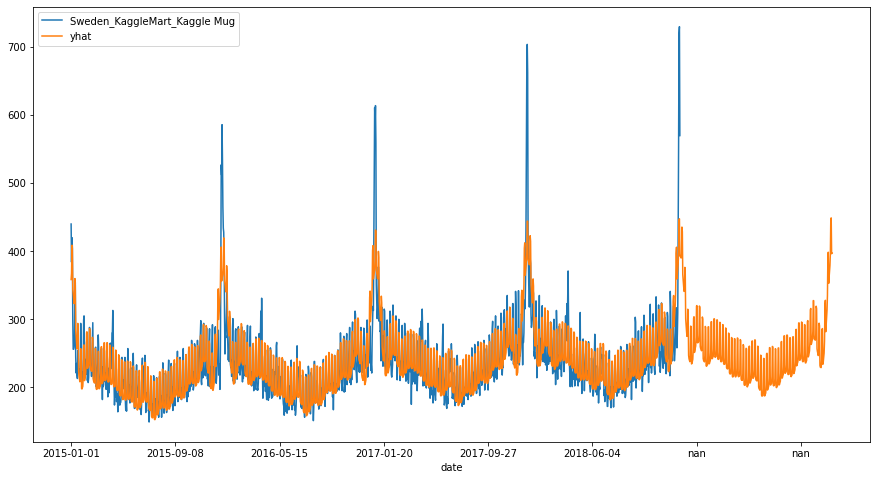

In [84]:
forecast = compSubResultDict['Sweden_KaggleMart_Kaggle Mug']
df_compareError = forecast[['ds', 'yhat']]
df_compareError = pd.concat([df_compareError, df_pivot[['Sweden_KaggleMart_Kaggle Mug']].reset_index()], axis=1)
df_compareError.plot(x='date', y=['Sweden_KaggleMart_Kaggle Mug', 'yhat'], kind='line', figsize=(15,8))

In [85]:
#Looks good enough to me...
compSubResultDict.keys()

dict_keys(['Finland_KaggleMart_Kaggle Hat', 'Finland_KaggleMart_Kaggle Mug', 'Finland_KaggleMart_Kaggle Sticker', 'Finland_KaggleRama_Kaggle Hat', 'Finland_KaggleRama_Kaggle Mug', 'Finland_KaggleRama_Kaggle Sticker', 'Norway_KaggleMart_Kaggle Hat', 'Norway_KaggleMart_Kaggle Mug', 'Norway_KaggleMart_Kaggle Sticker', 'Norway_KaggleRama_Kaggle Hat', 'Norway_KaggleRama_Kaggle Mug', 'Norway_KaggleRama_Kaggle Sticker', 'Sweden_KaggleMart_Kaggle Hat', 'Sweden_KaggleMart_Kaggle Mug', 'Sweden_KaggleMart_Kaggle Sticker', 'Sweden_KaggleRama_Kaggle Hat', 'Sweden_KaggleRama_Kaggle Mug', 'Sweden_KaggleRama_Kaggle Sticker'])

### Generating submission results

In [86]:
test_df = pd.read_csv('test.csv')
test_df.head()

,row_id,date,country,store,product
0,26298,2019-01-01,Finland,KaggleMart,Kaggle Mug
1,26299,2019-01-01,Finland,KaggleMart,Kaggle Hat
2,26300,2019-01-01,Finland,KaggleMart,Kaggle Sticker
3,26301,2019-01-01,Finland,KaggleRama,Kaggle Mug
4,26302,2019-01-01,Finland,KaggleRama,Kaggle Hat


In [195]:
# Let's filter the test dataframe, by each of the 18 series. Get the prediction, and then reconcatenate, and then sort by row_id, which should get us back to the submission result format.
finalResult = pd.DataFrame()
for key in list(compSubResultDict.keys()):

#     key = 'Finland_KaggleMart_Kaggle Hat'
    print(key)
    country = key.split('_')[0]
    store = key.split('_')[1]
    product = key.split('_')[2]
    curr_test_df = test_df[(test_df['country'] == country) & 
                           (test_df['store'] == store) & 
                           (test_df['product'] == product)].copy()
    print('Curr_test_df shape', curr_test_df.shape)
    curr_test_df = curr_test_df.sort_values('date')
    print(curr_test_df.head())
    predResult = compSubResultDict[key]['yhat'][-365:]
    print(predResult.head())
    print(predResult.tail())
    print(len(predResult.values))
    # print(compSubResultDict[key][['ds','yhat']][-365:]).tail()
    # print('predResult shape', predResult.shape)
    # print('predResult null shape', len(predResult[predResult.isnull()]))
    curr_test_df['num_sold'] = predResult.values
    # print('Prediction shape', compSubResultDict[key].shape)
    # print('Prediction min date', compSubResultDict[key]['ds'].min())
    # print('Prediction max date', compSubResultDict[key]['ds'].max())

    finalResult = finalResult.append(curr_test_df)
    # print('finalResult shape', finalResult.shape)
    print('curr_test_df null shape', curr_test_df[curr_test_df['num_sold'].isnull()].shape)

    

Finland_KaggleMart_Kaggle Hat
Curr_test_df shape (365, 5)
    row_id        date  country       store     product
1    26299  2019-01-01  Finland  KaggleMart  Kaggle Hat
19   26317  2019-01-02  Finland  KaggleMart  Kaggle Hat
37   26335  2019-01-03  Finland  KaggleMart  Kaggle Hat
55   26353  2019-01-04  Finland  KaggleMart  Kaggle Hat
73   26371  2019-01-05  Finland  KaggleMart  Kaggle Hat
1461    548.151102
1462    550.165233
1463    547.575335
1464    562.405910
1465    626.498677
Name: yhat, dtype: float64
1821    565.667152
1822    642.270610
1823    644.006837
1824    563.655703
1825    568.268450
Name: yhat, dtype: float64
365
curr_test_df null shape (0, 6)
Finland_KaggleMart_Kaggle Mug
Curr_test_df shape (365, 5)
    row_id        date  country       store     product
0    26298  2019-01-01  Finland  KaggleMart  Kaggle Mug
18   26316  2019-01-02  Finland  KaggleMart  Kaggle Mug
36   26334  2019-01-03  Finland  KaggleMart  Kaggle Mug
54   26352  2019-01-04  Finland  KaggleMart  

In [196]:
# pd.set_option('display.max_rows', None)
# curr_test_df.head(1000)

In [197]:
finalResult.tail()


,row_id,date,country,store,product,num_sold
6497,32795,2019-12-27,Sweden,KaggleRama,Kaggle Sticker,310.671392
6515,32813,2019-12-28,Sweden,KaggleRama,Kaggle Sticker,353.898111
6533,32831,2019-12-29,Sweden,KaggleRama,Kaggle Sticker,355.143170
6551,32849,2019-12-30,Sweden,KaggleRama,Kaggle Sticker,307.785533
6569,32867,2019-12-31,Sweden,KaggleRama,Kaggle Sticker,310.197809


In [198]:
print(finalResult[finalResult['num_sold'].isnull()]['country'].value_counts())
print(finalResult[finalResult['num_sold'].isnull()]['product'].value_counts())
print(finalResult[finalResult['num_sold'].isnull()]['store'].value_counts())

Series([], Name: country, dtype: int64)
Series([], Name: product, dtype: int64)
Series([], Name: store, dtype: int64)


In [199]:
# print(test_df['country'].value_counts())
# print(test_df['product'].value_counts())
# print(test_df['store'].value_counts())

In [200]:
finalResult.shape

(6570, 6)

In [201]:
test_df.shape

(6570, 5)

In [202]:
finalResult = finalResult.sort_values('row_id')

In [203]:
finalResult.tail(30)

,row_id,date,country,store,product,num_sold
6540,32838,2019-12-30,Norway,KaggleMart,Kaggle Mug,580.786081
6541,32839,2019-12-30,Norway,KaggleMart,Kaggle Hat,873.119466
6542,32840,2019-12-30,Norway,KaggleMart,Kaggle Sticker,262.540312
6543,32841,2019-12-30,Norway,KaggleRama,Kaggle Mug,1019.722370
6544,32842,2019-12-30,Norway,KaggleRama,Kaggle Hat,1542.291814
6545,32843,2019-12-30,Norway,KaggleRama,Kaggle Sticker,447.775112
6546,32844,2019-12-30,Sweden,KaggleMart,Kaggle Mug,396.379806
6547,32845,2019-12-30,Sweden,KaggleMart,Kaggle Hat,604.592487
6548,32846,2019-12-30,Sweden,KaggleMart,Kaggle Sticker,178.705672
6549,32847,2019-12-30,Sweden,KaggleRama,Kaggle Mug,706.147932


In [207]:
# finalResult.info
finalResult['num_sold'] = finalResult['num_sold'].astype('int')

In [208]:
finalResult.head()

,row_id,date,country,store,product,num_sold
0,26298,2019-01-01,Finland,KaggleMart,Kaggle Mug,355
1,26299,2019-01-01,Finland,KaggleMart,Kaggle Hat,548
2,26300,2019-01-01,Finland,KaggleMart,Kaggle Sticker,156
3,26301,2019-01-01,Finland,KaggleRama,Kaggle Mug,620
4,26302,2019-01-01,Finland,KaggleRama,Kaggle Hat,935


In [210]:
submission_df = finalResult[['row_id', 'num_sold']].to_csv('fb_prop_sub_int.csv', index=False)

In [87]:
# May not be the most efficient way, but good enough for now since the data is in slightly different format.
def lookupPrediction(row):
    forecast = compSubResultDict[
    return (row['date'], row['country'], row['store'])


In [90]:
test_df.apply(lookupPrediction, axis=1)

0       (2019-01-01, Finland, KaggleMart)
1       (2019-01-01, Finland, KaggleMart)
2       (2019-01-01, Finland, KaggleMart)
3       (2019-01-01, Finland, KaggleRama)
4       (2019-01-01, Finland, KaggleRama)
                      ...                
6565     (2019-12-31, Sweden, KaggleMart)
6566     (2019-12-31, Sweden, KaggleMart)
6567     (2019-12-31, Sweden, KaggleRama)
6568     (2019-12-31, Sweden, KaggleRama)
6569     (2019-12-31, Sweden, KaggleRama)
Length: 6570, dtype: object

In [29]:
# This function takes in one country_product_store combo
# def predictFuture(input_df, productLine):
#     # The productLine is country_store_product, e.g. "Finland_KaggleMart_Kaggle Hat"
#     # We will use that column as targetLabe, and then predict the year 2018, and then check the error.
#     m = Prophet()
#     df_target = input_df[[productLine]].iloc[0:-366]
#     df_target['ds'] = df_target.index
#     df_target['y'] = df_target[productLine]
#     df_target = df_target.reset_index()[['ds', 'y']]
#     df_target.head()
#     df_prop = pd.concat([df_target, df_pivot.drop(['Finland_KaggleMart_Kaggle Hat'], axis=1).reset_index().iloc[0:-366]], axis=1)
#     for column in input_df.columns:
#         if column in ['ds', 'y', 'date', productLine]:
#             print('Skipping column:' + column)
#             continue
#         else:
#             m.add_regressor(column)
#     m.fit(df_prop)
#     future = m.make_future_dataframe(periods=365)
#     print(future.tail())
#     forecast = m.predict(future)
#     return df_prop, forecast

In [30]:
# df_test = predictFuture(df_pivot, 'Finland_KaggleMart_Kaggle Hat')

In [31]:
# For each series, we will use the other 17 sale data as feature. 